# SeSiMe
### Sentence/Sequence Similarity Measure

### Mass spec side - how to filter peaks?
Import MS data and create documents.

Here: Use NOT Crusemann data, but other dataset where smilea are known for all spectra.
### here: GNPS Dataset of 11134 spectra with smiles.

In [1]:
# data locations
# Windows 
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
#mgf_file = PATH_MS_DATA + "GNPSLibraries_allSMILES.mgf"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
spectra = load_spectra(mgf_file)

Loaded 11134 molecules


In [4]:
# Load metadata (mostly needed later on: smiles)
from parsers import LoadMGF
ms1, ms2, metadata = LoadMGF(name_field='scans').load_spectra([mgf_file])

for spec in spectra:
    id = spec.spectrum_id
    spec.metadata = metadata[id]

## Inspecting the data

In [5]:
def peak_stats(spectra):
    peak_count = []
    parent_count = []
    rel_to_max_count = []

    for spec in spectra:
        peak_count.append(len(spec.peaks))
        parent_count.append(spec.precursor_mz)
        peak_ints = np.array(spec.peaks)[:,1]
        rel_to_max_count.append(len(np.where(peak_ints < 0.01*np.max(peak_ints))[0]))
        
    return peak_count, parent_count, rel_to_max_count

peak_count, parent_count, rel_to_max_count = peak_stats(spectra)

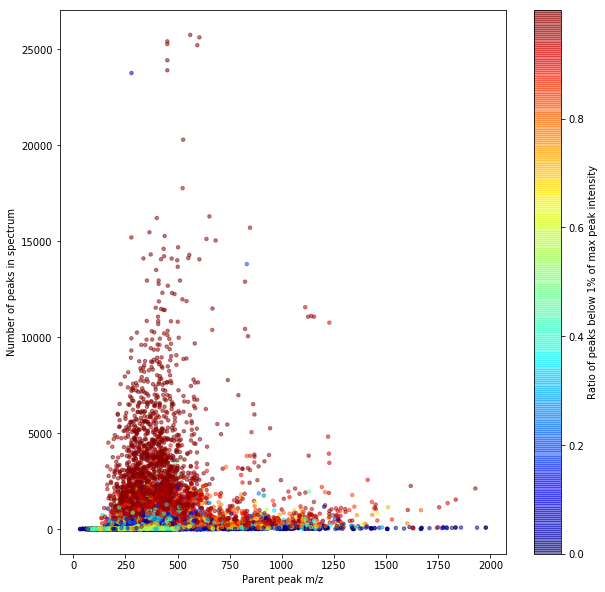

In [6]:
# plot relationship PARENT-MASS vs NUMBER OF PEAKS
from matplotlib import pyplot as plt
%matplotlib inline  

def plot_peak_stats(peak_count, parent_count, rel_to_max_count):
    fig = plt.figure(figsize=(10,10))
    plt.scatter(parent_count, peak_count, s=12, c= np.array(rel_to_max_count)/peak_count, alpha=0.5, cmap="jet")
    plt.xlabel("Parent peak m/z")
    plt.ylabel("Number of peaks in spectrum")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Ratio of peaks below 1% of max peak intensity", rotation=90)
    plt.show()
  
plot_peak_stats(peak_count, parent_count, rel_to_max_count)   

### Problems: 
- **To hetergeneous document lengths**. 

We here have spectra ranging from 1 to 25.000 peaks, which would lead to *vastly* different document lengths.

- **Spectra with too few peaks**

Below a certain number of peaks, spectra will become useless for further quantitative analysis...

In [7]:
print("No. of spectra with 10 or less peaks: ", len(np.where(np.array(peak_count) <= 10)[0]))
print("No. of spectra with 5 or less peaks: ", len(np.where(np.array(peak_count) <= 5)[0]))
print("No. of spectra with 3 or less peaks: ", len(np.where(np.array(peak_count) <= 3)[0]))

No. of spectra with 10 or less peaks:  1730
No. of spectra with 5 or less peaks:  909
No. of spectra with 3 or less peaks:  549


## Some first tests:
Try out to get a more homogeneous and reasonable number of peaks per spectrum.


### (1) Apply intensity threshold relative to highest peak
(here: discard peaks with intensities < 1% of highest peak) 

In [8]:
import copy
spectra2 = copy.deepcopy(spectra)

# TEST: try to scale the amount of filtering with the number of peaks present
def threshold_scaling(x, xfactor, peaks_desired):
    return (x - peaks_desired)**xfactor

for spec in spectra2:
    peaks = spec.peaks.copy()
    peaks_desired = 100
    if len(peaks) > peaks_desired:
        peaks = MS_functions.process_peaks(peaks, min_frag = 0.0, max_frag = 1000.0,
                     min_intensity_perc = 1.0,
                     exp_intensity_filter = None, #threshold_scaling(len(peaks), -0.6, peaks_desired),#0.01,
                     min_peaks = 50,)

    spec.peaks = peaks

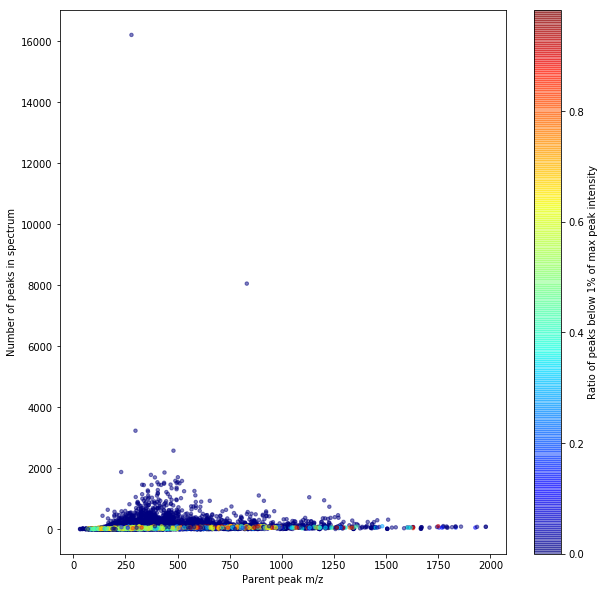

In [9]:
peak_count, parent_count, rel_to_max_count = peak_stats(spectra2)
plot_peak_stats(peak_count, parent_count, rel_to_max_count) 

### (2) Apply the intensity distribution based exponential cutoff filter 


In [10]:
spectra2 = copy.deepcopy(spectra)

min_peaks = 50

for spec in spectra2:
    peaks = spec.peaks.copy()
    if len(peaks) > min_peaks:
        peaks = MS_functions.process_peaks(peaks, min_frag = 0.0, max_frag = 1000.0,
                     min_intensity_perc = 0.0,
                     exp_intensity_filter = 0.01,
                     min_peaks = min_peaks,)

    spec.peaks = peaks

RuntimeError for  123  peaks. Use mean intensity as threshold.


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe-env\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\MS_functions.py:190: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe-env\lib\site-packages\scipy\optimize\minpack.py:780: RuntimeWarning: overflow encountered in multiply
  pcov = pcov * s_sq


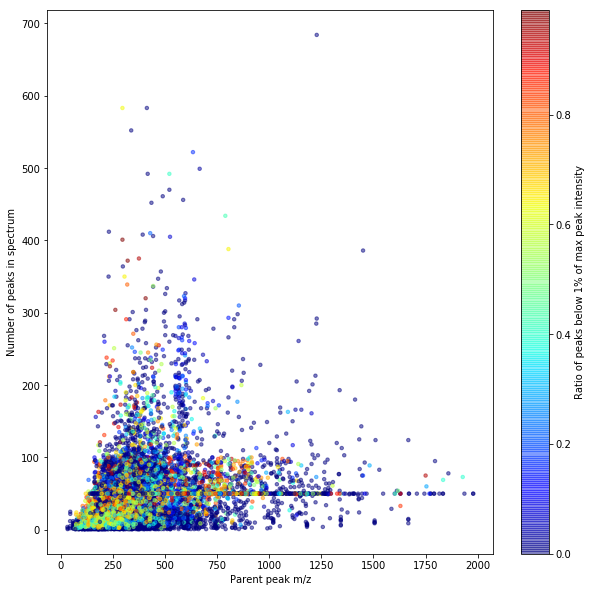

In [11]:
peak_count, parent_count, rel_to_max_count = peak_stats(spectra2)

plot_peak_stats(peak_count, parent_count, rel_to_max_count)  

### (3) Apply the intensity distribution based exponential cutoff filter 
(+ amount of filtering varies with number of peaks)

--> Actually doesn't really look much better than the previous approach.

In [12]:
spectra2 = copy.deepcopy(spectra)

# TEST: try to scale the amount of filtering with the number of peaks present
def threshold_scaling(x, xfactor, peaks_desired):
    return (x - peaks_desired)**xfactor

peaks_desired = 100
min_peaks = 50

for spec in spectra2:
    peaks = spec.peaks.copy()
    if len(peaks) > peaks_desired:
        peaks = MS_functions.process_peaks(peaks, min_frag = 0.0, max_frag = 1000.0,
                     min_intensity_perc = 0.0,
                     exp_intensity_filter = threshold_scaling(len(peaks), -0.6, peaks_desired),#0.01,
                     min_peaks = min_peaks,)

    spec.peaks = peaks

RuntimeError for  123  peaks. Use mean intensity as threshold.


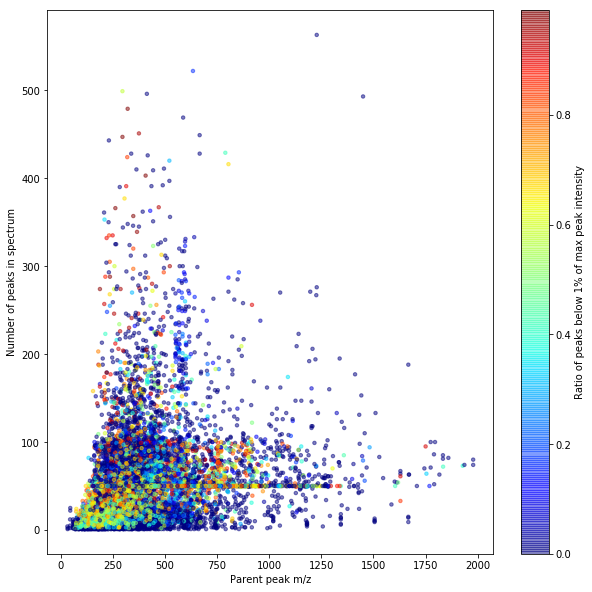

In [13]:
peak_count, parent_count, rel_to_max_count = peak_stats(spectra2)
plot_peak_stats(peak_count, parent_count, rel_to_max_count)  

## First impressions

All above methods work **get rid of the most excessive** amounts of peaks.

Using a min_peaks threshold further avoided the problem of **filtering out too many peaks**.

Now, however, many spectra are brought to exactly this minimum amount (see accumulation of dots around 50 peaks)!

### (4) Apply the intensity distribution based exponential cutoff filter 
+ fixed exp_intensity_filter = 0.01
+ use a min_peaks value that scales linearly with precursor m/z

In [14]:
spectra2 = copy.deepcopy(spectra)

min_peak_absolute = 10

# TEST: try to scale the min_peak filter
def min_peak_scaling(x, A, B):
    return int(A + B * x)

for spec in spectra2:
    peaks = spec.peaks.copy()
    min_peaks = min_peak_scaling(spec.precursor_mz, min_peak_absolute, 30/200)
    if len(peaks) > min_peaks:
        peaks = MS_functions.process_peaks(peaks, min_frag = 0.0, max_frag = 1000.0,
                     min_intensity_perc = 0.0,
                     exp_intensity_filter = 0.01,
                     min_peaks = min_peaks,)

    spec.peaks = peaks

RuntimeError for  92  peaks. Use mean intensity as threshold.


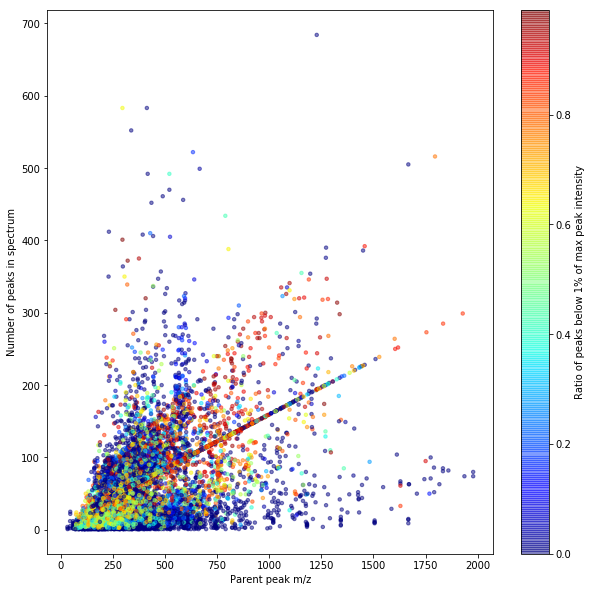

In [15]:
peak_count, parent_count, rel_to_max_count = peak_stats(spectra2)
plot_peak_stats(peak_count, parent_count, rel_to_max_count)  

### Remove spectra with too few peaks & create documents

In [16]:
min_peaks_absolute = 10
spectra_filtered = [copy.deepcopy(x) for x in spectra2 if len(x.peaks)>=min_peaks_absolute]
print("Take ", len(spectra_filtered), "peaks out of ", len(spectra), ".")

Take  9565 peaks out of  11134 .


In [17]:
MS_documents, MS_documents_intensity = MS_functions.create_MS_documents(spectra_filtered, 3)

  Created documents for  9565  of  9565  spectra.

In [18]:
# Have a look at how a document looks like:
print(MS_documents[0])

['peak_74.733', 'peak_79.017', 'peak_89.017', 'peak_89.038', 'peak_90.046', 'peak_95.046', 'peak_98.979', 'peak_105.045', 'peak_107.050', 'peak_117.034', 'peak_118.039', 'peak_134.672', 'peak_135.045', 'peak_135.276', 'peak_136.045', 'peak_136.998', 'peak_137.155', 'peak_145.030', 'peak_147.117', 'peak_160.087', 'peak_161.076', 'peak_162.587', 'peak_163.040', 'peak_163.077', 'peak_163.293', 'peak_164.042', 'peak_165.004', 'peak_165.400', 'peak_166.303', 'peak_167.149', 'peak_168.165', 'peak_172.581', 'peak_175.076', 'peak_181.057', 'peak_229.033', 'peak_237.012', 'peak_330.097', 'peak_330.142', 'loss_-0.023', 'loss_0.022', 'loss_93.107', 'loss_101.086', 'loss_149.062', 'loss_155.043', 'loss_157.538', 'loss_161.954', 'loss_162.970', 'loss_163.816', 'loss_164.719', 'loss_165.115', 'loss_166.077', 'loss_166.826', 'loss_167.042', 'loss_167.079', 'loss_167.532', 'loss_169.043', 'loss_170.032', 'loss_183.002', 'loss_185.089', 'loss_192.964', 'loss_193.121', 'loss_194.074', 'loss_194.843', 'l

In [19]:
len(MS_documents)  # number of spectra = number of documents

9565